In [1]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.steering.steer import organize_activations,get_steering_vector,run_model_with_steering,get_inputs_ending_in_belief
from typing import List, Tuple, Dict, Any

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import functools


/home/tassilo/repos/epsilon-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get the model checkpoints (.pt files) and the config

In [2]:
persister = HackyPersister(dir_path=pathlib.Path('./models/vfs4q106-rrxor'))
checkpoints = persister.get_model_checkpoints()
print(f"Checkpoints found: {len(checkpoints)}")
print(f"Last checkpoint: {checkpoints[-1]}")

Checkpoints found: 32
Last checkpoint: 496016000


In [3]:
train_config = persister.load_training_config()
print("\n".join(f"{k}: {v}" for k, v in train_config.items()))

seed: 42
n_ctx: 10
act_fn: relu
d_head: 16
d_model: 128
d_vocab: 2
n_heads: 4
n_iters: 25
n_layers: 4
attn_only: False
optimizer: sgd
batch_size: 64
num_epochs: 150000000
init_weights: True
weight_decay: 0
attention_dir: causal
learning_rate: 0.01
use_attn_scale: True
normalization_type: LN


# Initialize the RRXOR process
This library has a Process class that we use to define a data generating HMM.

The most important part of the process is the transition matrix, which defines the transitions between states. You can get it via `process.transition_matrix`. It is a numpy array of shape (num_emission, num_states, num_states), and defines the transition probabilities from state i to state j given emission k.

The process also has a `state_names_dict`, which is a dictionary mapping state names to state indices. You can get it via `process.state_names_dict`.


In [4]:
process = RRXOR()
print(process)

rrxor Process
Number of states: 5
Vocabulary length: 2
Transition matrix shape: (2, 5, 5)


In [5]:
process.transition_matrix

array([[[0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5],
        [0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [1. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0.5],
        [1. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ]]])

In [6]:
process.state_names_dict

{'S': 0, '0': 1, '1': 2, 'T': 3, 'F': 4}

# Visualizing the process

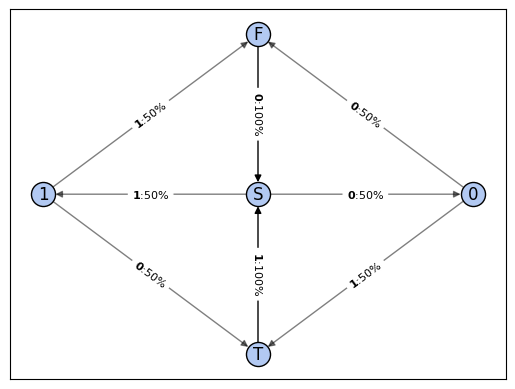

In [7]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

# Computing the Mixed-State Presentation

The computation of the MSP from the process is in two steps:
1. Compute a tree of that keeps track of belief states as nodes, and emissions as edges. This is called a `MixedStateTree` and you can get it via `process.derive_mixed_state_presentation(depth=N)`, where N is the maximum length of sequences you want to consider.
2. Once we have a tree, we can then compute the MSP via `msp_tree.build_transition_graph()`. This returns a transition matrix which we can then use to create another `Process` using the `TransitionMatrixProcess` class.

We go through these steps and then visualize the MSP.

In [8]:
mixed_state_tree = process.derive_mixed_state_presentation(depth=11)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

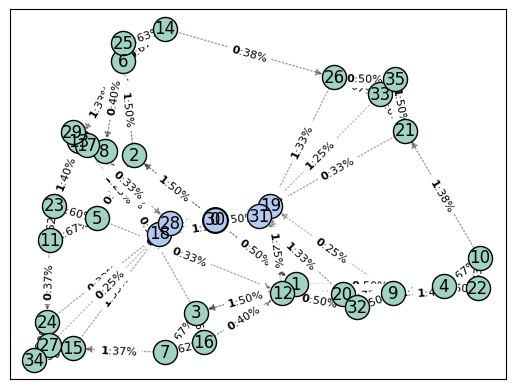

In [9]:
# make a process out of the transition matrix
from epsilon_transformers.process.processes import TransitionMatrixProcess
process = TransitionMatrixProcess(transition_matrix=MSP_transition_matrix)
graph = transition_matrix_to_graph(transition_matrix=MSP_transition_matrix)
visualize_graph(graph, draw_mixed_state=True, layout='spectral', draw_edge_labels=True, draw_color=False)


# Simplex Analysis

## Ground Truth Simplex

To get the ground truth simplex structure, we need to get all paths of any length on the mixed state tree, and their associated belief states. To do this, we use `mixed_state_tree.paths_and_belief_states`, which returns a list of tuples, where the first element is the path, and the second element is the belief state associated with it.



In [10]:
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

Path: 101000000, Belief: [1. 0. 0. 0. 0.]
Path: 01011110011, Belief: [1. 0. 0. 0. 0.]
Path: 011010, Belief: [0.  0.5 0.  0.5 0. ]
Path: 011011, Belief: [0.5  0.   0.25 0.   0.25]
Path: 011000, Belief: [0.66666667 0.         0.         0.         0.33333333]


In [11]:
# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

Number of Unique beliefs: 36 out of 1723


In [12]:
# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

(0.5, 0.25, 0.0, 0.0, 0.25) is indexed as 0
(0.33333, 0.0, 0.33333, 0.16667, 0.16667) is indexed as 1
(0.0, 0.0, 1.0, 0.0, 0.0) is indexed as 2
(0.0, 0.0, 0.5, 0.5, 0.0) is indexed as 3
(0.0, 0.66667, 0.0, 0.0, 0.33333) is indexed as 4


The simplex is a 4D structure, representing probability distributions over 5 hidden states, so we project down to 3D using PCA for visualization.



In [13]:
def run_visualization_pca(beliefs):
    pca = PCA(n_components=3)
    pca.fit(beliefs)

    return pca

def visualize_ground_truth_simplex_3d(beliefs, belief_labels, pca):

    beliefs_pca = pca.transform(beliefs)

    colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly
    fig = px.scatter_3d(beliefs_pca, x=0, y=1, z=2,
                        color=[str(i) for i in belief_labels],
                        color_discrete_sequence=colors)
    fig.update_layout(width=400, height=400)
    fig.show()

vis_pca = run_visualization_pca(list(msp_belief_index.keys()))
index = list(msp_belief_index.values())
visualize_ground_truth_simplex_3d(list(msp_belief_index.keys()),
                                  list(msp_belief_index.values()),
                                  vis_pca)



In [14]:
beliefs_3d = vis_pca.transform(list(msp_belief_index.keys()))
colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly

# make a 2d plot using the 0th and 1st dim of beliefs_3d
fig = px.scatter(beliefs_3d, x=0, y=2, 
                 color=[str(i) for i in list(msp_belief_index.values())],
                 title='2D Plot of MSP Beliefs',
                 labels={'x': 'PCA Dimension 1', 'y': 'PCA Dimension 2', 'color': 'Belief State'},
                 color_continuous_scale=colors,
                 size_max=1000)  # Increase the size of the dots

# Make the figure square
fig.update_layout(width=400, height=400)

fig.show()

# Find Simplex in Transformer Activations

First, we get all of the possible sequences generated by our HMM by getting all of the paths on the MSP, of length equal to the context length. We put them all in one batch so we can get the activations for all of them at once.


In [15]:
# now lets set up all the inputs as they arrive into the transformer
device = 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == train_config["n_ctx"]]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])

tensor([[0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 1, 0, 1, 0]], dtype=torch.int32)


Then, we get the belief states associated with each transformer input, using the `get_beliefs_for_transformer_inputs` function. The output of this function is a tuple of two tensors, where the first tensor is the belief states associated with each transformer input, and the second tensor is the indices of the beliefs associated with each transformer input. The shape of the belief states tensor is [batch, n_ctx, belief_dim], and the shape of the indices tensor is [batch, n_ctx].


In [16]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")


Transformer Input Beliefs: torch.Size([436, 10, 5]), Transformer Input Belief Indices: torch.Size([436, 10])


Next we get the activations from the transformer for the input. We use the `names_filter` argument to get the activations from the resid_post layers, which is the residual stream of the transformer after the attention and MLP have been added in.

In [17]:
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = persister.load_model(ckpt_num=checkpoints[-1], device=device)
logits, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'hook_resid_post' in x)
print(activations.keys())

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post'])


Next we define a function to run the linear regression between the activations and the belief states.
For the RRXOR process we concatenate the activations from the residual stream of all layers.
Using the `run_activation_to_beliefs_regression` function, we run the linear regression between the activations and the belief states. The outputs are the linear regression model, and the belief predictions, which are of shape [batch, n_ctx, belief_dim], that is, for each context position, we have a belief prediction over the 5 hidden states.

In [18]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions



In [19]:

device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = persister.load_model(ckpt_num=checkpoints[-1], device=device)
logits, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'hook_resid_post' in x)
print(activations.keys())

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post'])


In [67]:
acts = torch.concatenate([v for k, v in activations.items() if k == 'blocks.3.hook_resid_post'], dim=-1) #if k == 'blocks.3.hook_resid_post'
print(f"Shape of activations: {acts.shape}")
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(f"Shape of belief_predictions: {belief_predictions.shape}")


Shape of activations: torch.Size([436, 10, 128])
Shape of belief_predictions: (436, 10, 5)


## Visualization of regression results
We visualize the belief predictions in 3D, using the same PCA as before, and also do a 2D plot of the belief predictions.

In [21]:
belief_predictions_pca = vis_pca.transform(belief_predictions.reshape(-1, 5))

# now visualize in 3d
transformer_input_belief_indices_flattened = transformer_input_belief_indices.view(-1).cpu().numpy()
from plotly.subplots import make_subplots
from plotly import graph_objects as go

colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# put the groundtruth simplex on the left
ground_truth_beliefs = list(msp_belief_index.keys())
ground_truth_belief_labels = list(msp_belief_index.values())
ground_truth_beliefs_pca = vis_pca.transform(ground_truth_beliefs)

fig.add_trace(go.Scatter3d(x=ground_truth_beliefs_pca[:, 0],
                           y=ground_truth_beliefs_pca[:, 1],
                           z=ground_truth_beliefs_pca[:, 2],
                           mode='markers',
                           marker=dict(size=5, color=[colors[i] for i in ground_truth_belief_labels], opacity=1),
                           name='Ground Truth Beliefs'),
              row=1, col=1)

# put the belief predictions on the right
for belief in msp_belief_index.keys():
    b = msp_belief_index[belief]
    relevant_indices = np.where(transformer_input_belief_indices_flattened == b)[0]
    relevant_data = belief_predictions_pca[relevant_indices]
    if len(relevant_data) > 0:
        centers_of_mass = np.mean(relevant_data, axis=0)
    
        fig.add_trace(go.Scatter3d(x=[centers_of_mass[0]],
                                y=[centers_of_mass[1]],
                                z=[centers_of_mass[2]],
                                mode='markers',
                                name=f'Belief {b}',
                                marker=dict(size=5, color=colors[b], opacity=1)),
                    row=1, col=2)
        
fig.show()


In [22]:
# Transform the ground truth beliefs
beliefs_2d = vis_pca.transform(list(msp_belief_index.keys()))
colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly

# Create a subplot with two scatter plots
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter'}, {'type': 'scatter'}]])

# Plot the ground truth beliefs on the left
fig.add_trace(go.Scatter(x=beliefs_2d[:, 0], y=beliefs_2d[:, 2],
                         mode='markers',
                         marker=dict(size=10, color=[colors[i] for i in list(msp_belief_index.values())], opacity=1),
                         name=f'Beliefs'),
              row=1, col=1)

# Calculate and plot the centers of mass of the belief predictions on the right
for belief in msp_belief_index.keys():
    b = msp_belief_index[belief]
    relevant_indices = np.where(transformer_input_belief_indices_flattened == b)[0]
    relevant_data = belief_predictions_pca[relevant_indices]
    if len(relevant_data) > 0:
        centers_of_mass = np.mean(relevant_data, axis=0)
        fig.add_trace(go.Scatter(x=[centers_of_mass[0]], y=[centers_of_mass[2]],
                                 mode='markers',
                                 marker=dict(size=10, color=colors[b], opacity=1),
                                 name=f'Belief {b} Center of Mass'),
                      row=1, col=2)
        fig.add_trace(go.Scatter(x=relevant_data[:, 0], y=relevant_data[:, 2],
                                 mode='markers',
                                 marker=dict(size=4, color=colors[b], opacity=.05),
                                 name=f'Belief {b}'),
                      row=1, col=2)

# set x and y lime to -.75 to .75
fig.update_xaxes(range=[-.85, .85], row=1, col=2)
fig.update_yaxes(range=[-.85, .85], row=1, col=2)
fig.update_xaxes(range=[-.85, .85], row=1, col=1)
fig.update_yaxes(range=[-.85, .85], row=1, col=1)
# Update layout
fig.update_layout(title='2D PCA Projection of Beliefs',
                  xaxis_title='PCA Dimension 1', yaxis_title='PCA Dimension 2',
                  width=800, height=400,
                  annotations=[
                      dict(text="Ground Truth", x=0.2, y=1.05, showarrow=False, xref="paper", yref="paper"),
                      dict(text="Residual Stream", x=0.8, y=1.05, showarrow=False, xref="paper", yref="paper")
                  ])



## Collect activations

In [23]:
per_layer_belief_activations = organize_activations(activations, transformer_input_belief_indices, all_positions=True)

## Compute steering vector

In [24]:
regression.coef_.shape

(5, 512)

## Add the hooking function

In [109]:
state_1 = 31
state_2 = 21
per_layer_steering_vector = get_steering_vector(per_layer_belief_activations,state_1,state_2)

starting_vector = torch.zeros_like(per_layer_steering_vector['blocks.0.hook_resid_post'])
for layer_name, steering_vector in per_layer_steering_vector.items():
    starting_vector += steering_vector
same_vector_all_layers = starting_vector/len(per_layer_steering_vector)
same_vector_all_layers = {k:same_vector_all_layers for k in per_layer_steering_vector.keys()}


In [116]:
def steer_transformer(model, steering_dict: Dict[str, torch.Tensor], state_1=21, state_2=31, mult=1):
    # F = 31
    # T = 21
    prompts_with_belief_state_1 = get_inputs_ending_in_belief(transformer_inputs,transformer_input_belief_indices,state_1)
    prompts_with_belief_state_2 = get_inputs_ending_in_belief(transformer_inputs,transformer_input_belief_indices,state_2)

    steered_to_1=run_model_with_steering(model, prompts_with_belief_state_2, steering_dict,1 * mult)
    steered_to_2=run_model_with_steering(model, prompts_with_belief_state_1, steering_dict,-1 * mult)
    

    normal_1 = model(prompts_with_belief_state_1)
    normal_2 = model(prompts_with_belief_state_2)
    print(torch.norm(normal_1- steered_to_2))
    output_state_1 = normal_1[:,-1,:].softmax(1).detach()
    output_state_2 = normal_2[:,-1,:].softmax(1).detach()
    corrupted_output_state_1 = steered_to_2[:,-1,:].softmax(1).detach()
    corrupted_output_state_2 = steered_to_1[:,-1,:].softmax(1).detach()

    output_state_1 = normal_1[:,-1,:].softmax(1).detach()
    output_state_2 = normal_2[:,-1,:].softmax(1).detach()
    corrupted_output_state_1 = steered_to_2[:,-1,:].softmax(1).detach()
    corrupted_output_state_2 = steered_to_1[:,-1,:].softmax(1).detach()


    outputs =[output_state_1,output_state_2,corrupted_output_state_1,corrupted_output_state_2]
    zero_bars = {"state_1":0,"state_2":0,"corrupted_state_1":0,"corrupted_state_2":0}
    one_bars = {"state_1":0,"state_2":0,"corrupted_state_1":0,"corrupted_state_2":0}
    for i,output in enumerate(outputs):
        total = len(output)
        key = list(one_bars.keys())[i]
        one_bars[key] = sum(output[:,0].numpy())/total
        zero_bars[key] = sum(output[:,1].numpy())/total
    # Create a subplot with two scatter plots
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter'}, {'type': 'scatter'}]])

    # Plot the ground truth beliefs on the left
    fig.add_trace(go.Bar(x=["State T","State F", "State T->State F","State F-> State T"], y=list(zero_bars.values()),
                            name=f'Probability to output 0'),
                row=1, col=1)
    fig.add_trace(go.Bar(x=["State T","State F", "State T->State F","State F-> State T"], y=list(one_bars.values()),
                            name=f'Probability to output 1'),
                row=1, col=2)
    fig.update_layout(title='Output probabilities',
                    yaxis_title='Probabilities', xaxis_title='Model belief state',
                    width=800, height=400,
                    )
    fig.update_yaxes(range=[0, 1], row=1, col=2)
    fig.update_yaxes(range=[0, 1], row=1, col=1)
    fig.show()



In [73]:
activations.keys()

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post'])

In [124]:


from collections import defaultdict
F_state =torch.Tensor([0,0,0,0,1])
T_state =torch.Tensor([0,0,0,1,0])
 
steering_dicts = defaultdict(list)
# steering_dict ={}

for key in activations.keys():
    new_steering_dicts =[]

    acts = torch.concatenate([v for k, v in activations.items() if k == key], dim=-1) #if k == 'blocks.3.hook_resid_post'
    print(f"Shape of activations: {acts.shape}")
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    print(f"Shape of belief_predictions: {belief_predictions.shape}")
    displacement =  T_state- F_state
    inverse =np.linalg.pinv(regression.coef_)

    new_steering_vector =torch.Tensor(inverse @ displacement.numpy())
    # steering_dict[key] = new_steering_vector

    for new_key in activations.keys():
        new_steering_dicts.append({new_key: new_steering_vector})
    steering_dicts[key].append(new_steering_dicts)



Shape of activations: torch.Size([436, 10, 128])
Shape of belief_predictions: (436, 10, 5)
Shape of activations: torch.Size([436, 10, 128])
Shape of belief_predictions: (436, 10, 5)
Shape of activations: torch.Size([436, 10, 128])
Shape of belief_predictions: (436, 10, 5)
Shape of activations: torch.Size([436, 10, 128])
Shape of belief_predictions: (436, 10, 5)


In [134]:



from collections import defaultdict
F_state =torch.Tensor([0,0,0,0,1])
T_state =torch.Tensor([0,0,0,1,0])
 
steering_dicts = defaultdict(list)
# steering_dict ={}

acts = torch.concatenate([v for k, v in activations.items()], dim=-1) #if k == 'blocks.3.hook_resid_post'
print(f"Shape of activations: {acts.shape}")
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)

new_steering_dicts =[]

print(f"Shape of belief_predictions: {belief_predictions.shape}")
displacement =  T_state- F_state
inverse =np.linalg.pinv(regression.coef_)

new_steering_vector =torch.Tensor(inverse @ displacement.numpy())

steering_dict = {'blocks.0.hook_resid_post': new_steering_vector[:128],
                 'blocks.1.hook_resid_post': new_steering_vector[128:256],
                    'blocks.2.hook_resid_post': new_steering_vector[256:384],
                    'blocks.3.hook_resid_post': new_steering_vector[384:512]}

for k,v in steering_dict.items():
    print(k,v.shape)
steer_transformer(model,steering_dict,mult=4)


Shape of activations: torch.Size([436, 10, 512])
Shape of belief_predictions: (436, 10, 5)
blocks.0.hook_resid_post torch.Size([128])
blocks.1.hook_resid_post torch.Size([128])
blocks.2.hook_resid_post torch.Size([128])
blocks.3.hook_resid_post torch.Size([128])
tensor(70.1168, grad_fn=<LinalgVectorNormBackward0>)


In [113]:
steer_transformer(model, same_vector_all_layers, mult=1)

tensor(184.6872, grad_fn=<LinalgVectorNormBackward0>)


In [123]:
steer_transformer(model, steering_dict, mult=1)

RuntimeError: The size of tensor a (128) must match the size of tensor b (512) at non-singleton dimension 2

In [121]:
for key,steering_dict in steering_dicts.items():
    for new_dict in steering_dict[0]:
        print(f"Steering vector: {key}, Displacement in block: {[x for x in new_dict][0]}")
        steer_transformer(model, new_dict, mult=1)

Steering vector: blocks.0.hook_resid_post, Displacement in block: blocks.0.hook_resid_post
tensor(11.4022, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.0.hook_resid_post, Displacement in block: blocks.1.hook_resid_post
tensor(4.2978, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.0.hook_resid_post, Displacement in block: blocks.2.hook_resid_post
tensor(2.5776, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.0.hook_resid_post, Displacement in block: blocks.3.hook_resid_post
tensor(2.3692, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.1.hook_resid_post, Displacement in block: blocks.0.hook_resid_post
tensor(35.6259, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.1.hook_resid_post, Displacement in block: blocks.1.hook_resid_post
tensor(27.2909, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.1.hook_resid_post, Displacement in block: blocks.2.hook_resid_post
tensor(13.4060, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.1.hook_resid_post, Displacement in block: blocks.3.hook_resid_post
tensor(7.2808, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.2.hook_resid_post, Displacement in block: blocks.0.hook_resid_post
tensor(61.9512, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.2.hook_resid_post, Displacement in block: blocks.1.hook_resid_post
tensor(45.0588, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.2.hook_resid_post, Displacement in block: blocks.2.hook_resid_post
tensor(53.1465, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.2.hook_resid_post, Displacement in block: blocks.3.hook_resid_post
tensor(36.0125, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.3.hook_resid_post, Displacement in block: blocks.0.hook_resid_post
tensor(80.2593, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.3.hook_resid_post, Displacement in block: blocks.1.hook_resid_post
tensor(74.2317, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.3.hook_resid_post, Displacement in block: blocks.2.hook_resid_post
tensor(69.4074, grad_fn=<LinalgVectorNormBackward0>)


Steering vector: blocks.3.hook_resid_post, Displacement in block: blocks.3.hook_resid_post
tensor(79.6470, grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
stee

In [ ]:
steer_transformer(model, 

In [200]:
outputs =[output_state_1,output_state_2,corrupted_output_state_1,corrupted_output_state_2]
zero_bars = {"state_1":0,"state_2":0,"corrupted_state_1":0,"corrupted_state_2":0}
one_bars = {"state_1":0,"state_2":0,"corrupted_state_1":0,"corrupted_state_2":0}
for i,output in enumerate(outputs):
    total = len(output)
    key = list(one_bars.keys())[i]
    one_bars[key] = sum(output[:,0].numpy())/total
    zero_bars[key] = sum(output[:,1].numpy())/total

In [201]:
# Create a subplot with two scatter plots
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter'}, {'type': 'scatter'}]])

# Plot the ground truth beliefs on the left
fig.add_trace(go.Bar(x=["State T","State F", "State T->State F","State F-> State T"], y=list(zero_bars.values()),
                         name=f'Probability to output 0'),
              row=1, col=1)
fig.add_trace(go.Bar(x=["State T","State F", "State T->State F","State F-> State T"], y=list(one_bars.values()),
                         name=f'Probability to output 1'),
              row=1, col=2)
fig.update_layout(title='Output probabilities',
                  yaxis_title='Probabilities', xaxis_title='Model belief state',
                  width=800, height=400,
                  )
fig.update_yaxes(range=[0, 1], row=1, col=2)
fig.update_yaxes(range=[0, 1], row=1, col=1)

